1) Установка и импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import missingno as msno

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBRFClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from joblib import dump, load

In [2]:
import warnings
warnings.filterwarnings('ignore')

2) EDA и предобработка данных

In [3]:
# Загрузка необходимого набора данных
df=pd.read_csv(r"ai4i2020.csv")
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# Перевод категориальных признаков в числовой (интервальный) вид
encoder = ce.OrdinalEncoder(cols=['Type','Failure Type'])
df = encoder.fit_transform(df)
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,1,298.1,308.6,1551,42.8,0,0,1
1,2,L47181,2,298.2,308.7,1408,46.3,3,0,1
2,3,L47182,2,298.1,308.5,1498,49.4,5,0,1
3,4,L47183,2,298.2,308.6,1433,39.5,7,0,1
4,5,L47184,2,298.2,308.7,1408,40.0,9,0,1


In [5]:
# Мапинг категориальных-интервальных признаков
print('Мапинг для столбца: ' + encoder.mapping[0].get('col'))
print(encoder.mapping[0].get('mapping'))
print('---'*8)
print('Мапинг для столбца: ' + encoder.mapping[1].get('col'))
print(encoder.mapping[1].get('mapping'))

Мапинг для столбца: Type
M      1
L      2
H      3
NaN   -2
dtype: int64
------------------------
Мапинг для столбца: Failure Type
No Failure                  1
Power Failure               2
Tool Wear Failure           3
Overstrain Failure          4
Random Failures             5
Heat Dissipation Failure    6
NaN                        -2
dtype: int64


In [6]:
# перевод в градусы Цельсия из градусов Кельвина [1 K = -272.15 °C  ] 
df["Air temperature [K]"] = df["Air temperature [K]"] - 272.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 272.15

# переименование в градусы Цельсия
df.rename(columns={"Air temperature [K]" : "Air temperature [°C]","Process temperature [K]" : "Process temperature [°C]"},inplace=True)

In [7]:
# Обработки названий признаков
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace("[°c]", '')
df.columns = df.columns.str.replace("[", '')
df.columns = df.columns.str.replace("]", '')
df

,udi,productid,type,airtemperature,processtemperature,rotationalspeedrpm,torquenm,toolwearmin,target,failuretype
0,1,M14860,1,25.95,36.45,1551,42.8,0,0,1
1,2,L47181,2,26.05,36.55,1408,46.3,3,0,1
2,3,L47182,2,25.95,36.35,1498,49.4,5,0,1
3,4,L47183,2,26.05,36.45,1433,39.5,7,0,1
4,5,L47184,2,26.05,36.55,1408,40.0,9,0,1
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,1,26.65,36.25,1604,29.5,14,0,1
9996,9997,H39410,3,26.75,36.25,1632,31.8,17,0,1
9997,9998,M24857,1,26.85,36.45,1645,33.4,22,0,1
9998,9999,H39412,3,26.85,36.55,1408,48.5,25,0,1


In [8]:
# описание набора данных
df.describe().style.background_gradient()

,udi,type,airtemperature,processtemperature,rotationalspeedrpm,torquenm,toolwearmin,target,failuretype
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.500000,1.800600,27.854930,37.855560,1538.776100,39.986910,107.951000,0.033900,1.105100
std,2886.895680,0.600230,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.628883
min,1.000000,1.000000,23.150000,33.550000,1168.000000,3.800000,0.000000,0.000000,1.000000
25%,2500.750000,1.000000,26.150000,36.650000,1423.000000,33.200000,53.000000,0.000000,1.000000
50%,5000.500000,2.000000,27.950000,37.950000,1503.000000,40.100000,108.000000,0.000000,1.000000
75%,7500.250000,2.000000,29.350000,38.950000,1612.000000,46.800000,162.000000,0.000000,1.000000
max,10000.000000,3.000000,32.350000,41.650000,2886.000000,76.600000,253.000000,1.000000,6.000000


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 1, 'udi'),
  Text(1, 1, 'productid'),
  Text(2, 1, 'type'),
  Text(3, 1, 'airtemperature'),
  Text(4, 1, 'processtemperature'),
  Text(5, 1, 'rotationalspeedrpm'),
  Text(6, 1, 'torquenm'),
  Text(7, 1, 'toolwearmin'),
  Text(8, 1, 'target'),
  Text(9, 1, 'failuretype')])

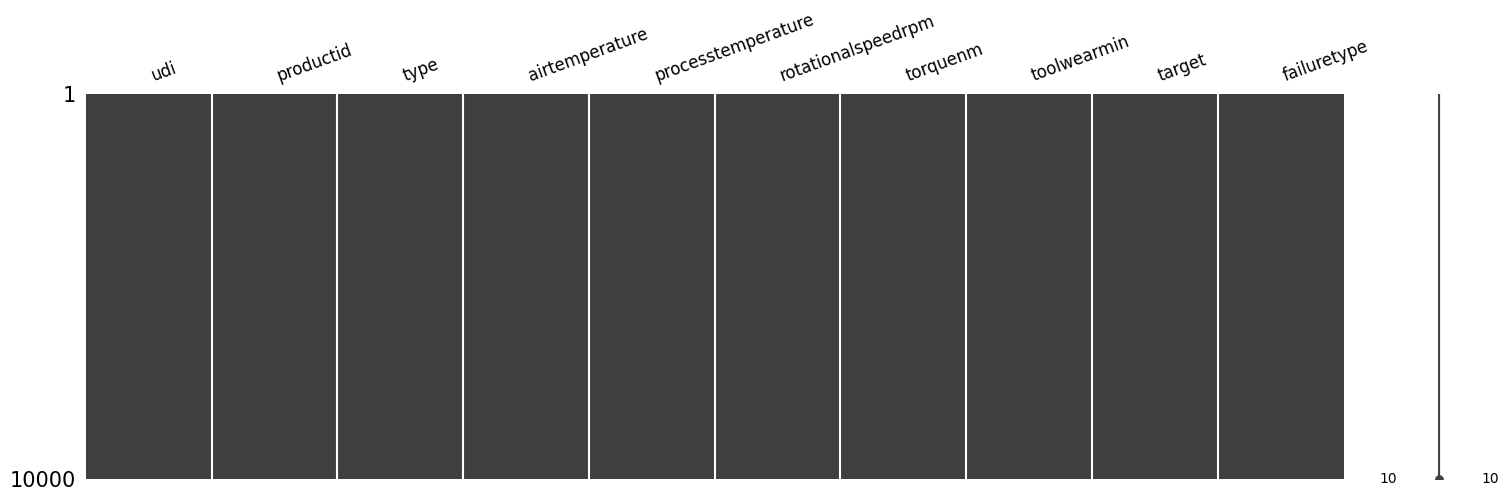

In [9]:
# Проверка на наличие пропущенных значений
msno.matrix(df, figsize=(18,5), fontsize=12)
plt.xticks(rotation=20)

<Axes: >

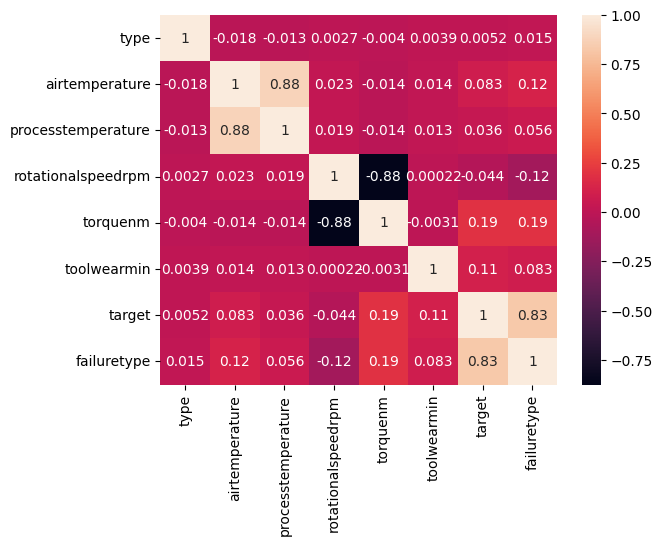

In [10]:
# Матриа корреляций
sns.heatmap(df.iloc[:,2:].corr(), annot=True)

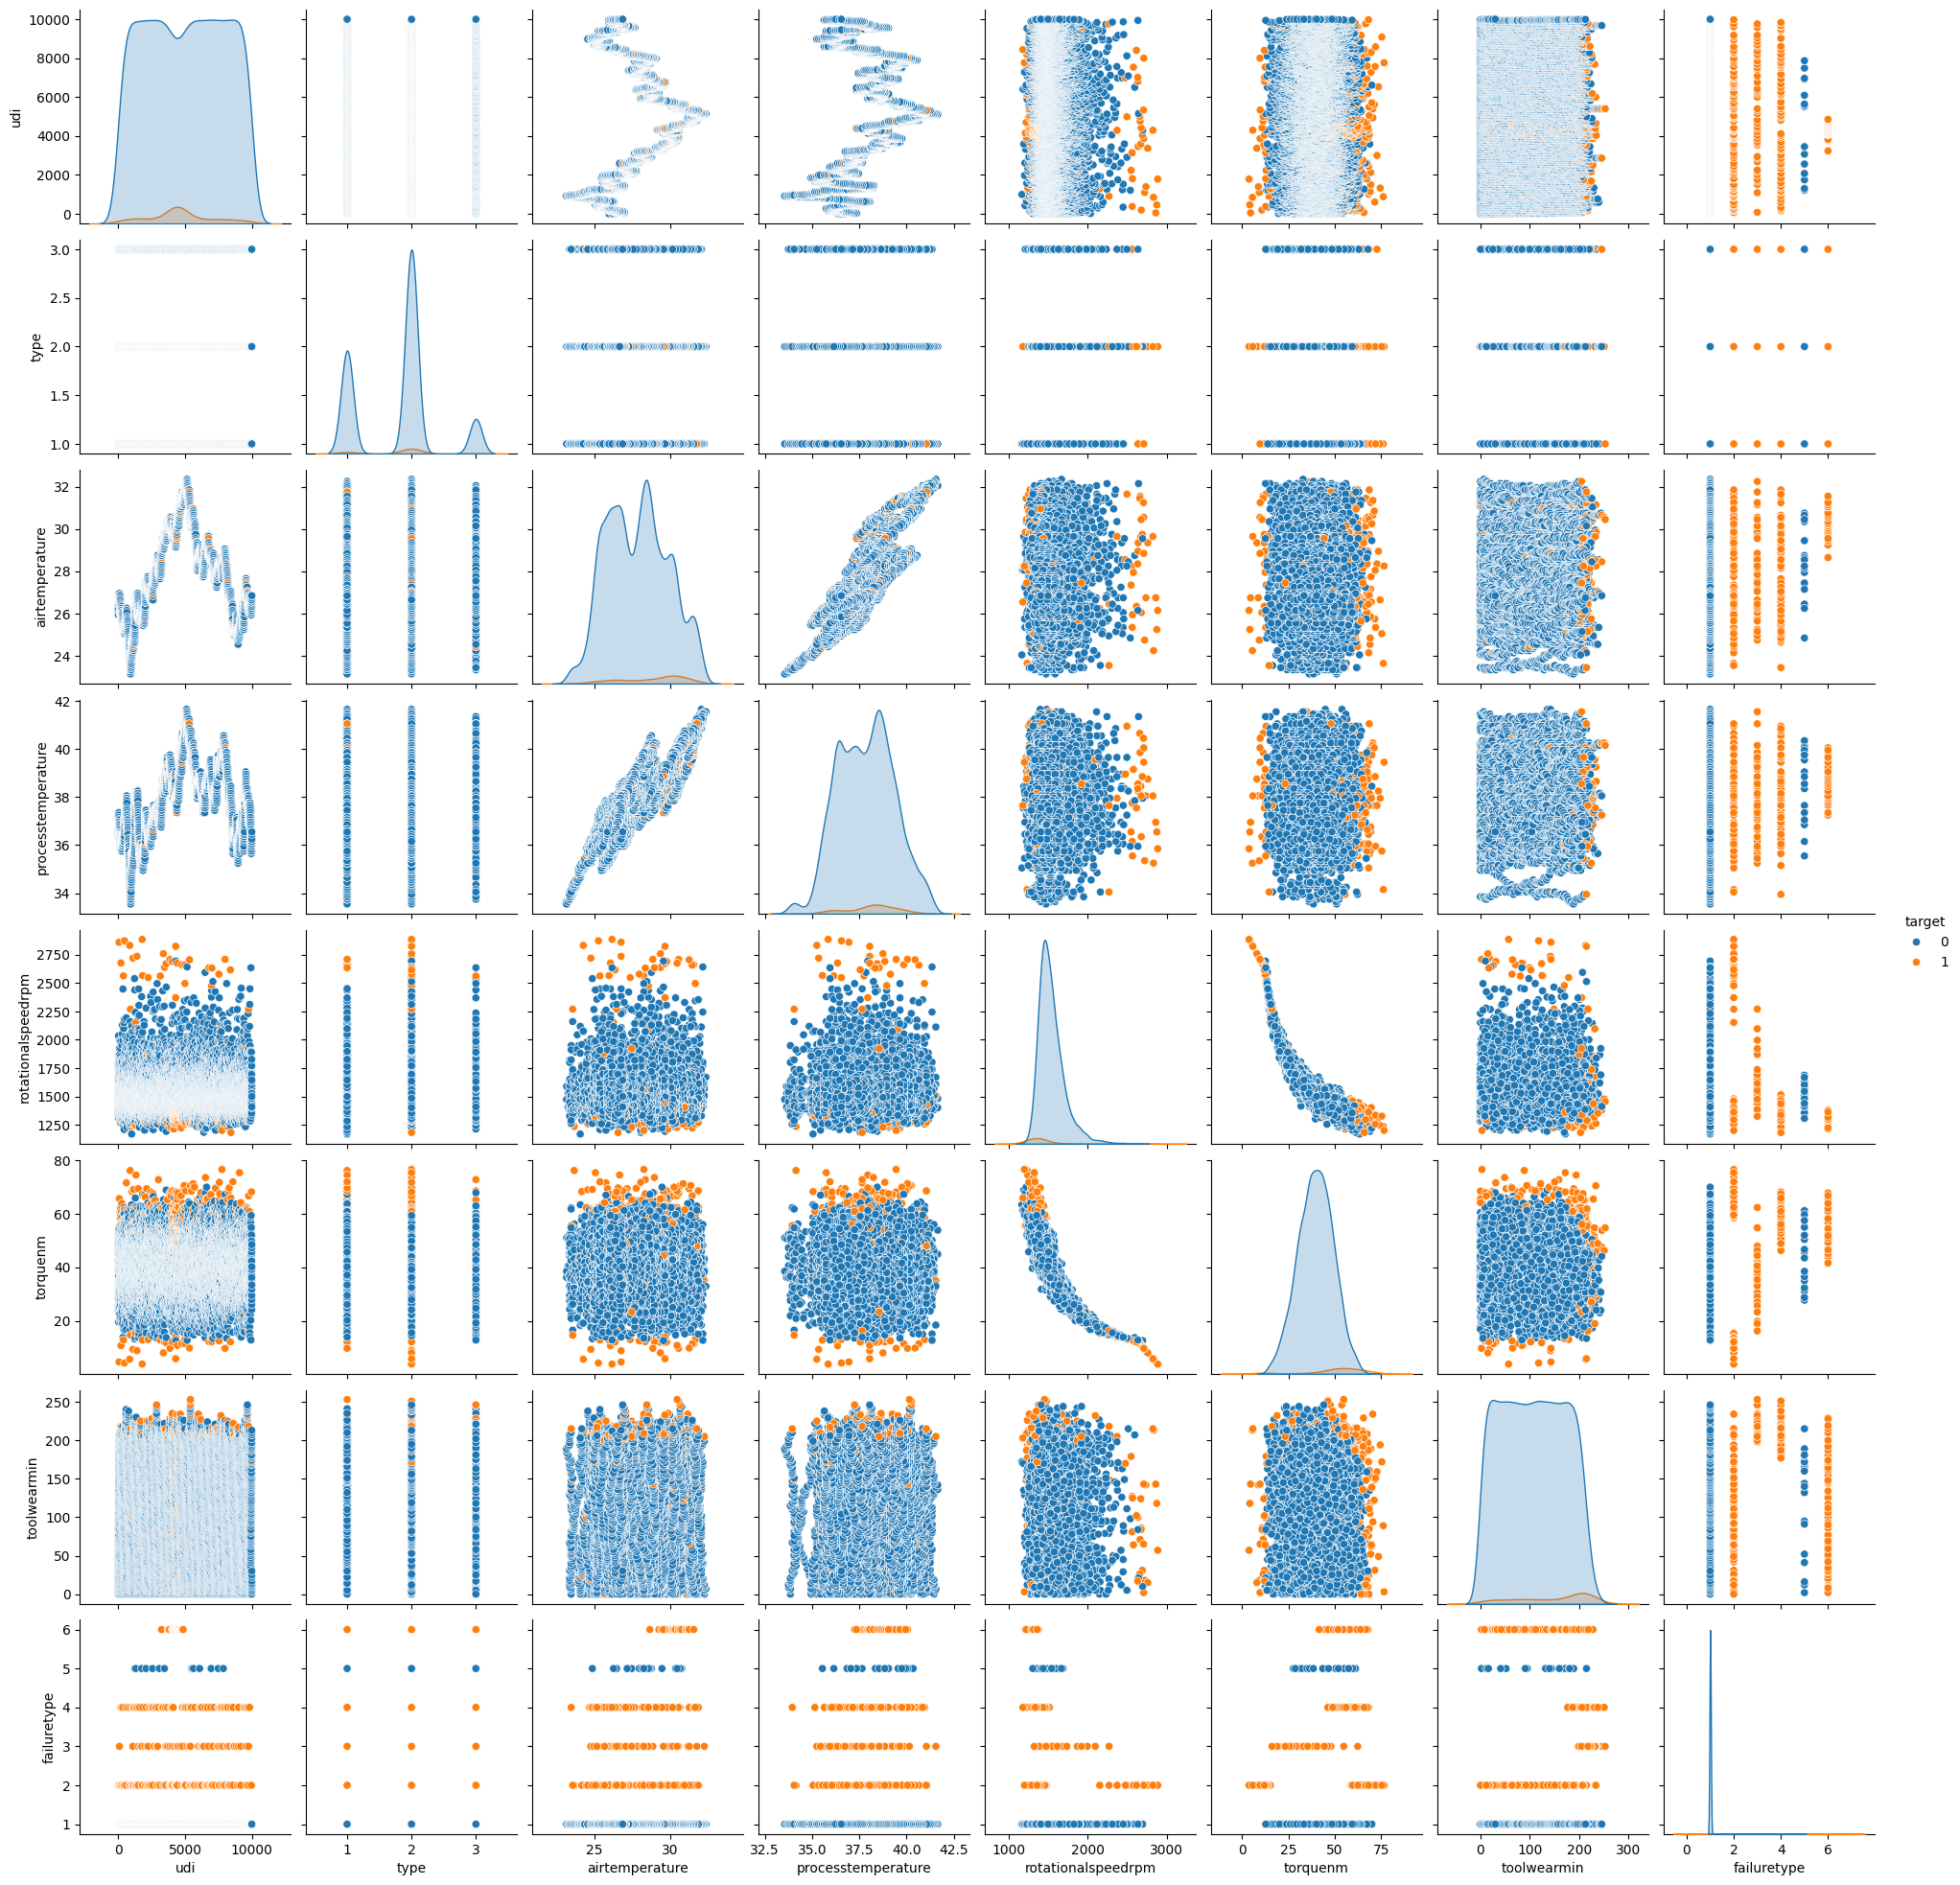

In [11]:
# Графики и распределения по каждому из признаков
sns.pairplot(df, hue = 'target')

Text(0.5, 1.0, 'Type')

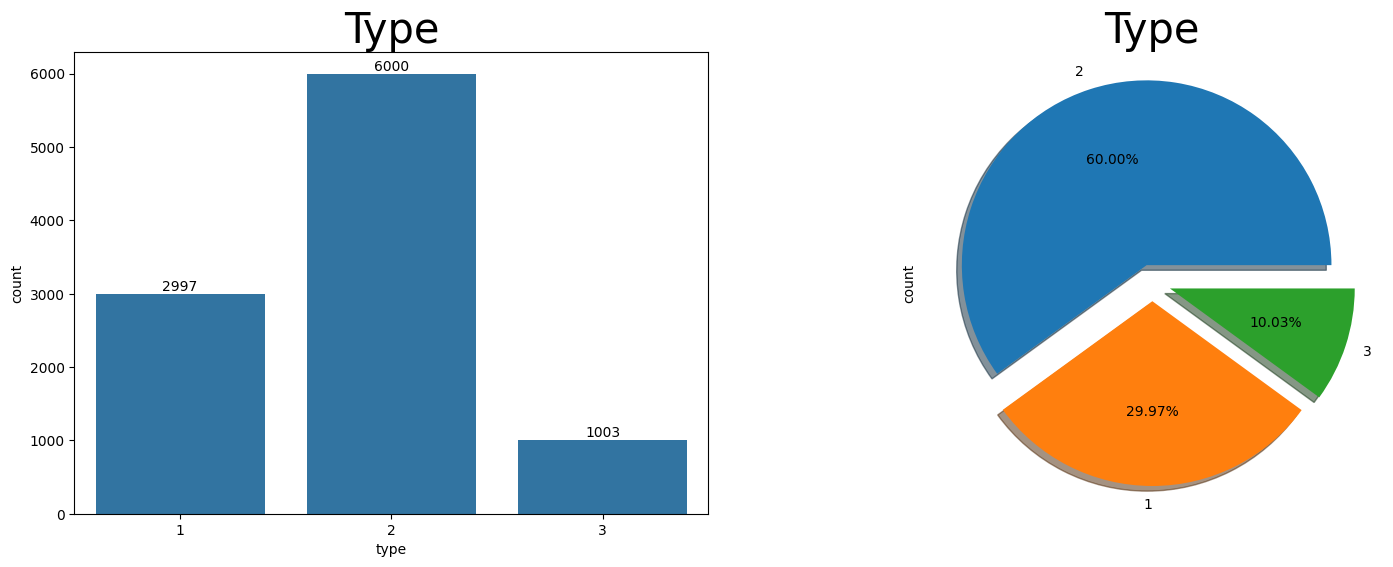

In [12]:
# Диаграммы по типу оборудования
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='type', data=df)
ax.bar_label(ax.containers[0])
plt.title("Type", fontsize=30,color='black')
ax =plt.subplot(1,2,2)
ax=df['type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True)
ax.set_title(label = "Type", fontsize = 30,color='black')

Text(0.5, 1.0, 'Target')

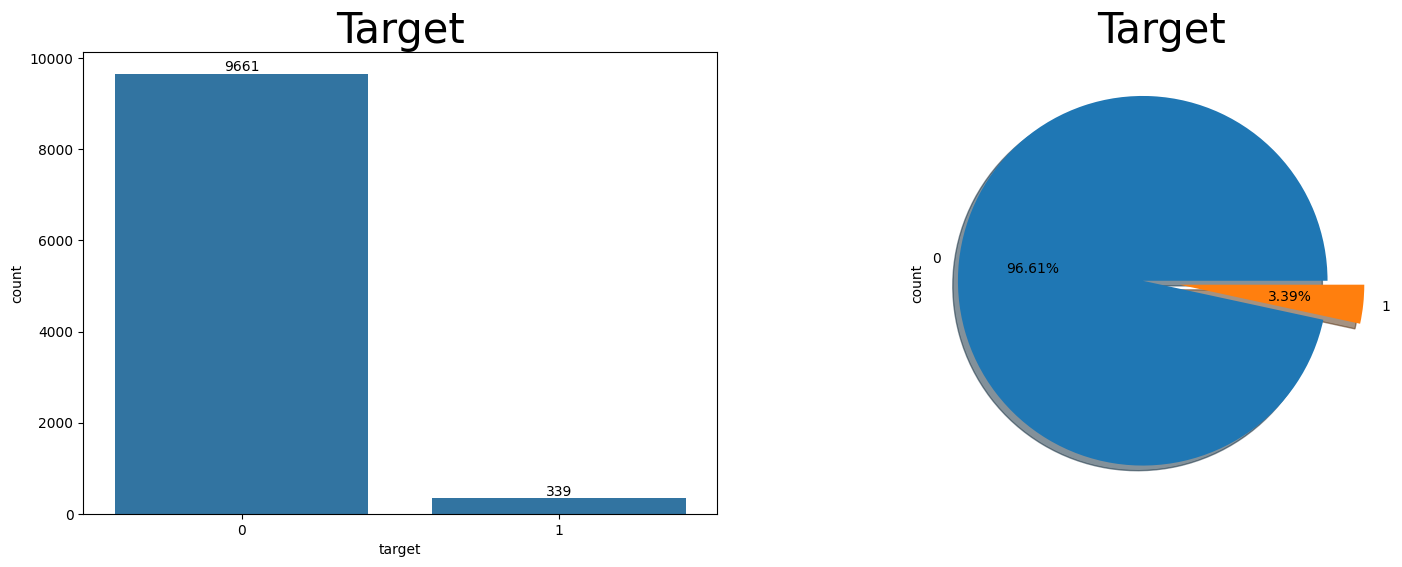

In [13]:
# Целевой параметр
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='target', data=df)
ax.bar_label(ax.containers[0])
plt.title("Target", fontsize=30,color='black')
ax =plt.subplot(1,2,2)
ax=df['target'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True)
ax.set_title(label = "Target", fontsize = 30,color='black')

In [14]:
# Подготовка моделей
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('XGBRFC', XGBRFClassifier()))
models.append(('XGBC', XGBClassifier()))

3) Оценка различных моделей

In [15]:
X = df.iloc[:,2:8]
Y = df.iloc[:,8:9]

LR: 0.139580 (0.068483)
LDA: 0.358548 (0.078980)
KNN: 0.193091 (0.068317)
DTC: 0.718141 (0.061996)
NB: 0.204267 (0.067244)
SVC: 0.005929 (0.015120)
ABC: 0.428198 (0.097765)
XGBRFC: 0.473423 (0.084323)
XGBC: 0.693972 (0.087969)


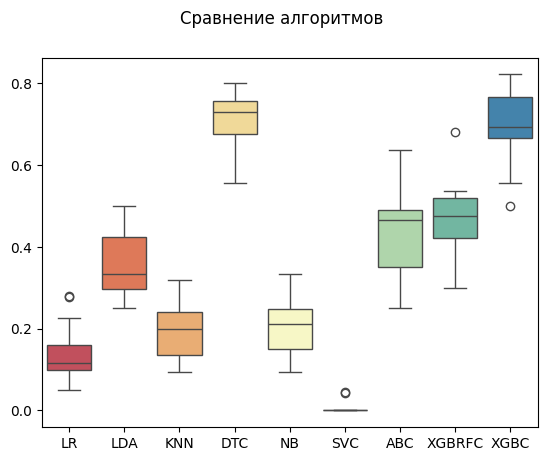

In [16]:
# Оценим каждую модель
results = []
names = []
scoring = 'recall'
for name, model in models:
    kfold = model_selection.KFold(n_splits=15, random_state=42, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# Построение боксплота для сравнения алгоритмов
fig = plt.figure()
fig.suptitle('Сравнение алгоритмов')
ax = fig.add_subplot(111)
sns.boxplot(results, palette='Spectral')
ax.set_xticklabels(names)
plt.show()

4) Разделение выборки на train и test

In [17]:
# Деление набора данных для обучения и теста
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

5) Обучение выбранной модели - XGBoostClassifier

In [18]:
#оценка различных метрик
def model_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("ROC AUC Score:", roc_auc)
    print("Confusion Matrix:\n", conf_matrix)

Training Accuracy    : 100.0 %
Model Accuracy Score : 98.45 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.79      0.67      0.73        61

    accuracy                           0.98      2000
   macro avg       0.89      0.83      0.86      2000
weighted avg       0.98      0.98      0.98      2000

--------------------------------------------------------


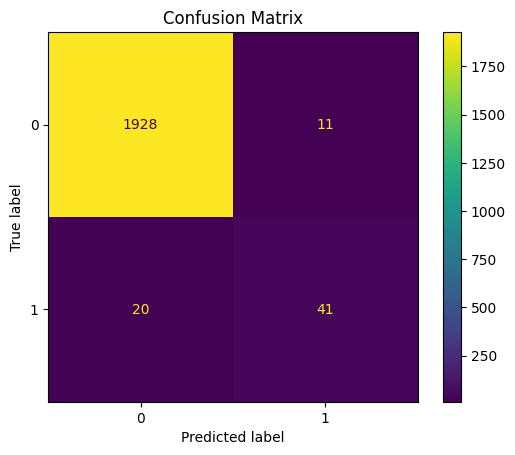

Accuracy: 0.9845
Precision: 0.7884615384615384
Recall: 0.6721311475409836
F1-Score: 0.7256637168141593
ROC AUC Score: 0.8332290601036533
Confusion Matrix:
 [[1928   11]
 [  20   41]]


In [19]:
# XGBoost Classifier
XGB_model = XGBClassifier(random_state=42)
XGB_model.fit(X_train, y_train)
y_pred_xgboost = XGB_model.predict(X_test)

XGB_model_train = round(XGB_model.score(X_train, y_train) * 100, 2)
XGB_model_accuracy = round(accuracy_score(y_pred_xgboost, y_test) * 100, 2)

print("Training Accuracy    :",XGB_model_train ,"%")
print("Model Accuracy Score :",XGB_model_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_xgboost))
print("\033[1m--------------------------------------------------------\033[0m")

cm = confusion_matrix(y_test, y_pred_xgboost, labels=XGB_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=XGB_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

model_metrics(y_test, y_pred_xgboost)

6) Сохранение выбранной модели - XGBoostClassifier

In [20]:
#сохранение модели
dump(XGB_model, r'XGB_model.joblib')

['XGB_model.joblib']

In [36]:
a = XGB_model.predict_proba(X_test.iloc[[794]])
print(a)
a.tolist()[0][0]

[[0.7389971 0.2610029]]


0.7389971017837524